In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/6r/r5dfhtxd75g2p4pkybxl8jcc0000gn/T/ipykernel_98175/1205883626.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [8]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/"
# train/val/test dir CHANGE TO 64 or 255
data_file_path = data_dir + "/preprocessed_data/train_64_noreroofs.npy"
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "/preprocessed_data/val_64_noreroofs.npy"

In [9]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [10]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)


Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [11]:
sample = data[0]  # get a sample from the dataset
print(type(sample))
print(len(sample))  # check the length of the tuple
print(sample[0])  # check the shape of the image tensor

<class 'tuple'>
3
tensor([[[0.6471, 0.5647, 0.5059,  ..., 0.0000, 0.0863, 0.2235],
         [0.7569, 0.7569, 0.6784,  ..., 0.0000, 0.0000, 0.1882],
         [0.6902, 0.7569, 0.7608,  ..., 0.0000, 0.0000, 0.0471],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1451, 0.1647],
         [0.0196, 0.0824, 0.0431,  ..., 0.0196, 0.1333, 0.1647],
         [0.6824, 0.6941, 0.6510,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6824, 0.6157, 0.5725,  ..., 0.0000, 0.0667, 0.2824],
         [0.7843, 0.8039, 0.7412,  ..., 0.0000, 0.0000, 0.2157],
         [0.7373, 0.7961, 0.7647,  ..., 0.0000, 0.0000, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1176, 0.1333],
         [0.0196, 0.0824, 0.0706,  ..., 0.0196, 0.0941, 0.1294],
         [0.7059, 0.6980, 0.6588,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6471, 0.5647, 0.5059,  ..., 0.0000, 0.0000, 0.1294],
         [0.7490, 0.7569, 0.6745,  ..., 0.0000, 0.0000, 0.0745],
         [0.6510, 0.7216, 0.7020,  ..., 

In [12]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
print(fixed_x.shape)
# torch.Size([32, 3, 255, 255]) or torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])


In [13]:
# Set default parameters
image_channels = fixed_x.size(1)

img_dim = fixed_x.size(-1)
print(img_dim)

64


In [14]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim = img_dim, image_channels=image_channels, z_dim=128,device=device).to(device)

In [16]:
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_VAE_64_1.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1024, bias=True)
)

# Build binary classifier on latents

In [17]:
from torch.autograd import Variable

## Helper functions:

In [18]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
# classifying two images as reroof if the probability is greater than the threshold

def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):    # model is the classification model
    v_1 = np.hstack((latent_1,latent_2)) # concatenate the two latent vectors
    v_2 = np.hstack((latent_2,latent_1)) # concatenate the two latent vectors
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
    p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
    prob = max([p_1.item(),p_2.item()]) # take the max probability
    return prob >= prob_threshold # return 1 if the probability is greater than the threshold, 0 otherwise

In [19]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
# If no transition detected, returns 0
def gen_predictions(latents,meta,model,prob_threshold=0.5): 
    out = [] 
    for i in range(len(latents)): # for each building
        hold = [] # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0])) # append the address
        trans_year = 0 # initialize the transition year
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold): # if the pair is classified as a reroof
                trans_year = j + 2013   # set the transition year to the year of the pair
                break
        hold.append(trans_year)  # append the transition year
        hold.append(int(meta[i][1])) # append the actual transition year
        out.append(hold) # append the list to the output
    return np.array(out) # return the output as an array

In [20]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
# If no transition detected, returns 0
def get_max_prob(latents,meta,model,prob_threshold=0.5): 
    out = []
    for i in range(len(latents)): # for each building
        hold = []  # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0]))   # append the address
        trans_year = 0
        temp = [] # hold the probabilities
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            latent_1 = latents[i][j] # get the latent vectors
            latent_2 = latents[i][j+1] # get the latent vectors
            v_1 = np.hstack((latent_1,latent_2)) # concatenate the latent vectors
            v_2 = np.hstack((latent_2,latent_1)) # concatenate the latent vectors
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
            p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
            prob = max([p_1.item(),p_2.item()]) # take the max probability
            temp.append(prob) # append the probability
        index = np.argmax(temp)     # get the index of the max probability
        if temp[index]>=prob_threshold: # if the max probability is greater than the threshold
            trans_year = 2013 + index # set the transition year to the year of the max probability 
        hold.append(trans_year) # append the transition year
        hold.append(int(meta[i][1]))       # append the actual transition year
        out.append(hold)    # append the list to the output
    return np.array(out)    # return the output as an array

In [21]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
# No reroof is defined as a building that has no reroof in the dataset
# Reroof is defined as a building that has a reroof in the dataset
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):   
    no_reroof_pred = [] # hold the predictions for buildings with no reroof
    reroof_pred = [] # hold the predictions for buildings with a reroof
    hold = acc_metric(latents,meta, net ,threshold) # get the predictions
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2]))) # print the overall accuracy
    for i in hold: # for each building
        if int(i[2])==0:    # if the building has no reroof
            no_reroof_pred.append(int(int(i[1]) == 0))      # append the prediction
        else:
            reroof_pred.append(int(i[1]==i[2]))         # append the prediction
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [22]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):     
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [23]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
# Generates latents for all buildings in dataloader
def gen_latents(dataloader, model): # generate latents for all buildings in dataloader
    latents = [] # hold the latents for the buildings
    meta = [] # hold the meta data for the buildings
    for i in dataloader: # for each building
        images = i[0] # get the images
        _, z, _, _ = model(images.to(device)) # get the latents
        z = z.detach().cpu().numpy()    # detach the latents in order to append to list
        latents.append(z)  # append the latents
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])     # append the meta data
    latents = np.array(latents)     # convert the latents to an array
    return latents, meta    

In [24]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
# Generates all possible pairs of latent images and their label 1:reroof, 0:no reroof
# Used for training binary classifier

def gen_binary_data(latents, meta):         # generate all possible pairs of latent images and their label 1:reroof, 0:no reroof
    data_hold = []  # hold the latent pairs
    label_hold = []     # hold the labels
    for i in range(len(latents)):   # for each building
        for j in range(len(latents[i])):    # for each latent vector
            for k in range(len(latents[i])):        # for each latent vector
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))      # append the latent pair
                year_j = 2012+j < meta[i][1]        # get the year of the latent vector
                year_k = 2012+k < meta[i][1]        # get the year of the latent vector
                label_hold.append(float(year_j != year_k))    # append the label
    data_hold = np.array(data_hold)     # convert the data to an array
    label_hold = np.array(label_hold)   # convery the labels to an array
    
    return data_hold, label_hold

## Load the data

In [25]:
# z_dim = 128 is the dimension of the latent space
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + 'roofnet_VAE_64_1.pth'))
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs.npy"

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [26]:
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [27]:
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [28]:
latents, meta = gen_latents(binary_dataloader, model)
print(latents.shape)

(150, 7, 128)


In [29]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)
print(val_latents.shape)

(25, 7, 128)


In [30]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)
print(test_latents.shape)

(55, 7, 128)


In [31]:
data_hold, label_hold = gen_binary_data(latents, meta)
print(data_hold.shape)

(7350, 256)


In [32]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)
print(val_hold.shape)

(1225, 256)


In [33]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)
print(test_hold.shape)

(2695, 256)


In [34]:
print(test_hold)

[[ 0.49220964  0.69742614 -0.44174626 ... -0.42518747 -0.4582469
   0.33236986]
 [ 0.49220964  0.69742614 -0.44174626 ...  0.23891874 -0.18332599
  -0.09195571]
 [ 0.49220964  0.69742614 -0.44174626 ... -0.37736124 -0.2984838
   0.32502788]
 ...
 [-0.15971091  0.08374229 -0.11520575 ...  0.11424081  0.08577335
  -0.11285058]
 [-0.15971091  0.08374229 -0.11520575 ...  0.07481571 -0.0034657
  -0.09287841]
 [-0.15971091  0.08374229 -0.11520575 ...  0.00926574  0.07023031
  -0.18133184]]


### Create Balanced dataset from the test dataset

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
data_resampled, label_resampled = smote.fit_resample(test_hold, test_label)

## Load the model

In [36]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function    
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



# Models' Robustness

## Robustness with Data Interpolation

## Iteration through model runs, same noise

### Accuracy for original imbalanced data

['sdr_kfold_shap_10_aplha03_25_1000_l1', 'sir_intensity_total_shap_10_aplha03', 'binary_classifier_sota_10', 'sdr_average_10_aplha03_1000_l1']
{'sdr_kfold_shap_10_aplha03_25_1000_l1': [0.883821892393321, 0.8173283858998145, 0.6726530612244898, 0.5745454545454545, 0.5269016697588126, 0.4899072356215214, 0.465974025974026, 0.4544341372912801, 0.447012987012987, 0.4404823747680891], 'sir_intensity_total_shap_10_aplha03': [0.8866419294990722, 0.8280148423005566, 0.6945083487940631, 0.5982189239332095, 0.5516512059369202, 0.5158812615955473, 0.4995918367346938, 0.4829684601113173, 0.4761410018552876, 0.46708719851576996], 'binary_classifier_sota_10': [0.89291280148423, 0.8289795918367349, 0.6771799628942486, 0.5765491651205937, 0.5148051948051948, 0.4806679035250464, 0.46367346938775506, 0.4458627087198515, 0.44096474953617804, 0.43001855287569574], 'sdr_average_10_aplha03_1000_l1': [0.8880890538033395, 0.8281632653061225, 0.6782560296846012, 0.5824860853432282, 0.5304638218923933, 0.495547

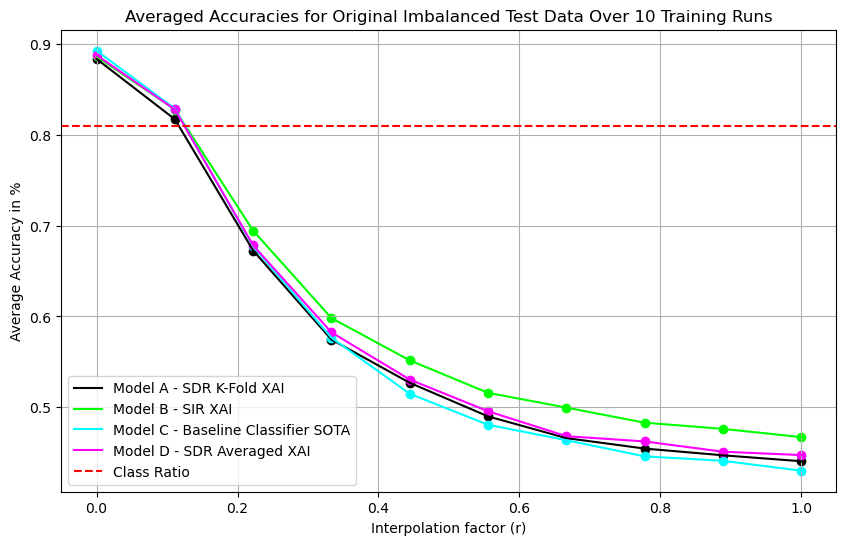

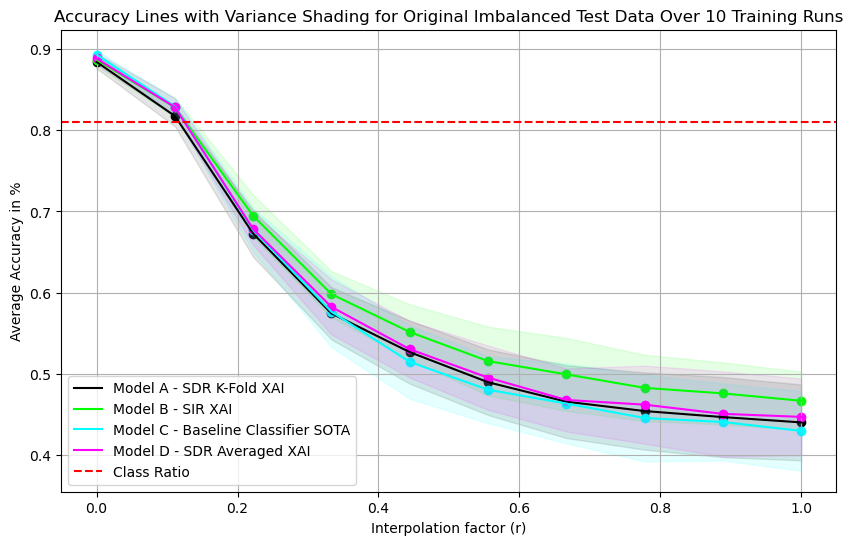

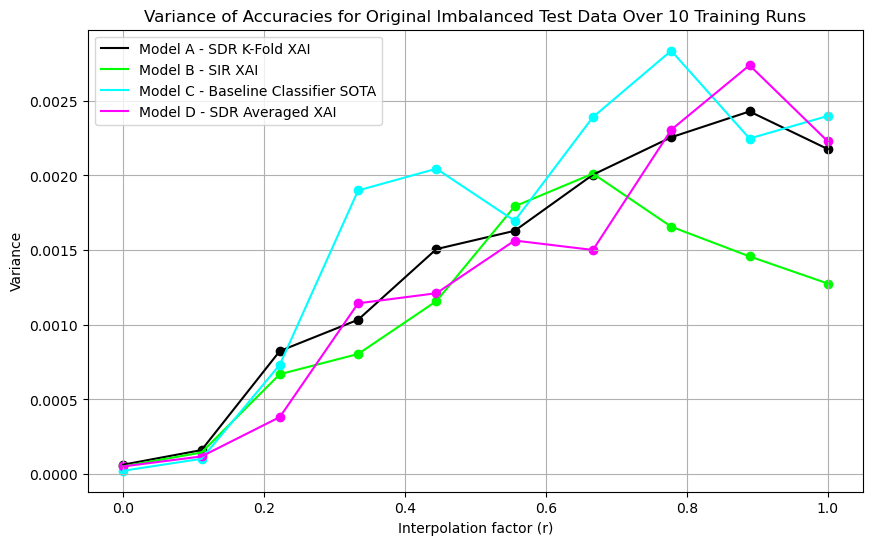

In [39]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# interpolation with Gaussian noise 
def interpolate_with_given_noise(data, r):

    # calculate the range for Gaussian 
    noise_range = (data.max(axis=0) - data.min(axis=0)) 
    
    # generate Gaussian noise with mean 0 and the calculated standard deviation
    noise = np.random.normal(0, np.abs(noise_range), size=data.shape)
    
    return (1 - r) * data + r * noise
 
    
# evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise):
    interpolated_data = interpolate_with_given_noise(data, r)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"

model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)

results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

for r in r_values:
    # generate noise once for this r-value, so every model gets the same noise
    noise = np.random.randn(*test_hold.shape)

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # list all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)

            accuracy = evaluate_model_on_interpolated_data(test_hold, test_label, model, device, r, noise)
            accuracies.append(accuracy)

        results.setdefault(folder, []).append(np.mean(accuracies))
        variances.setdefault(folder, []).append(np.var(accuracies))
print(results)

# add majority class ratio     
majority_class_ratio = max(np.mean(test_label), 1 - np.mean(test_label))

# model names dictionary
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

# color dictionary for the models
color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  

# Plot 1: just the accuracy lines for each model
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)  # Use .get() for safe access
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Averaged Accuracies for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: accuracy lines for each model with the variance shown as the filled space
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name) 
    std_devs = np.sqrt(variances[model_file_name])
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)
    plt.fill_between(r_values, 
                     np.array(accuracies) - std_devs, 
                     np.array(accuracies) + std_devs, 
                     color=color, alpha=0.1)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")

plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Accuracy Lines with Variance Shading for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: just the variance lines for each model
plt.figure(figsize=(10, 6))
for model_file_name, variance in variances.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name) 
    plt.plot(r_values, variance, label=label, color=color)
    plt.scatter(r_values, variance, color=color)
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# convert results to a DataFrame
df_results = pd.DataFrame(results)
df_results['r_value'] = r_values

# save results to a CSV file
df_results.to_csv(os.path.join(base_dir, 'average_accuracies_imbalanced.csv'), index=False)

# convert variances to a DataFrame
df_variances = pd.DataFrame(variances)
df_variances['r_value'] = r_values

# save variances to a CSV file
df_variances.to_csv(os.path.join(base_dir, 'variances_imbalanced.csv'),
                     index=False)



### Accuracy for class balanced test data

['sdr_kfold_shap_10_aplha03_25_1000_l1', 'sir_intensity_total_shap_10_aplha03', 'binary_classifier_sota_10', 'sdr_average_10_aplha03_1000_l1']


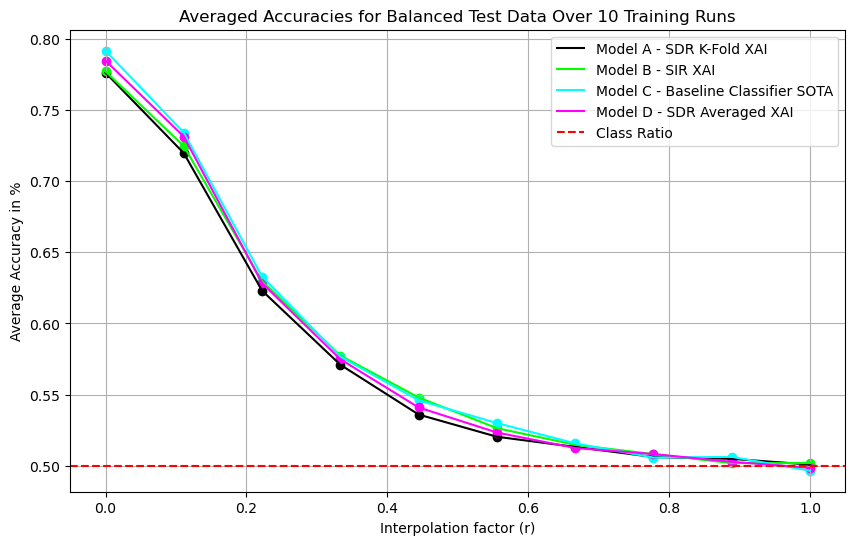

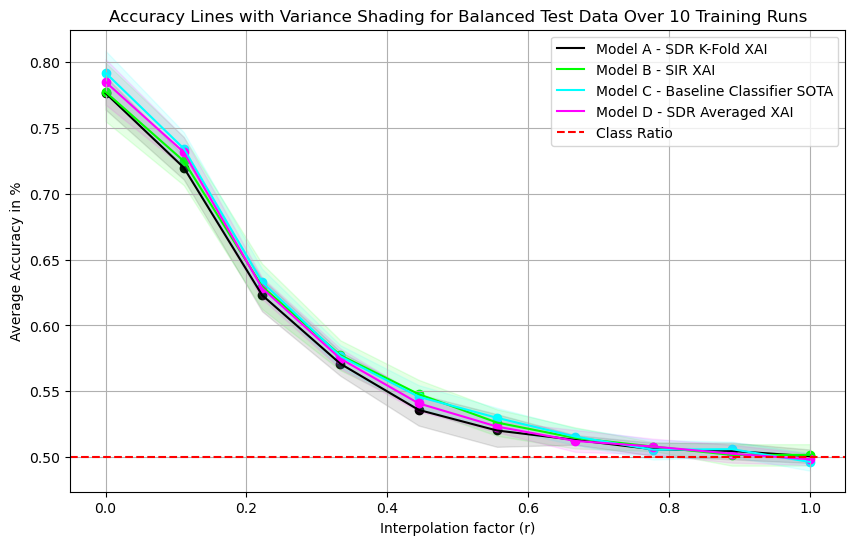

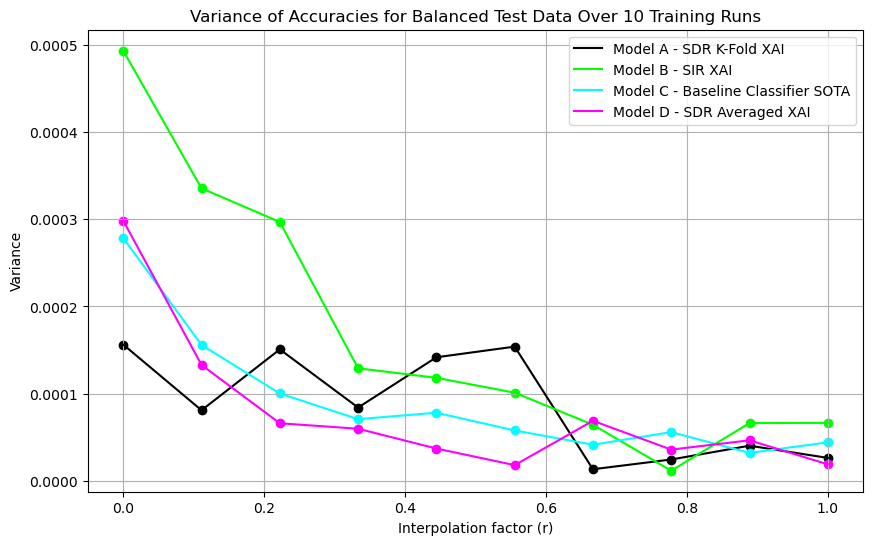

In [42]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# interpolation with Gaussian noise as a percentage of the feature range
def interpolate_with_given_noise(data, r):
    # calculate the range for Gaussian noise based on the percentage
    noise_range = (data.max(axis=0) - data.min(axis=0)) 
    
    # generate Gaussian noise with mean 0 and the calculated standard deviation
    noise = np.random.normal(0, np.abs(noise_range), size=data.shape)
    
    return (1 - r) * data + r * noise

# Evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise):
    interpolated_data = interpolate_with_given_noise(data, r)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

# Directory containing all model type folders, insert needed folder
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"

# List all model type folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)

results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

for r in r_values:
    # Generate noise once for this r-value, so every model gets the same noise
    noise = np.random.randn(*data_resampled.shape)

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)
            # data type
            accuracy = evaluate_model_on_interpolated_data(data_resampled, label_resampled, model, device, r, noise)
            accuracies.append(accuracy)
        
        # Store the average accuracy and variance for this r-value in the results
        results.setdefault(folder, []).append(np.mean(accuracies))
        variances.setdefault(folder, []).append(np.var(accuracies))

# add majoruty class ratio     
majority_class_ratio = max(np.mean(label_resampled), 1 - np.mean(label_resampled))
# Corrected model names mapping
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}


# Color mapping for the models
color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}


# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found

# Plot 1: Just the accuracy lines for each model with scatter points
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)  # Add scatter points
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Averaged Accuracies for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Accuracy lines for each model with the variance shown as the filled space and scatter points
plt.figure(figsize=(10, 6))
for model_file_name, accuracies in results.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    std_devs = np.sqrt(variances[model_file_name])
    plt.plot(r_values, accuracies, label=label, color=color)
    plt.scatter(r_values, accuracies, color=color)  # Add scatter points
    plt.fill_between(r_values, 
                     np.array(accuracies) - std_devs, 
                     np.array(accuracies) + std_devs, 
                     color=color, alpha=0.1)
plt.axhline(y=majority_class_ratio, color='r', linestyle='--', label="Class Ratio")
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy in %")
plt.legend()
plt.grid(True)
plt.title("Accuracy Lines with Variance Shading for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Just the variance lines for each model with scatter points
plt.figure(figsize=(10, 6))
for model_file_name, variance in variances.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    plt.plot(r_values, variance, label=label, color=color)
    plt.scatter(r_values, variance, color=color)  # Add scatter points
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies for Balanced Test Data Over 10 Training Runs")
plt.show()

# Save results and variances to CSV files
df_results = pd.DataFrame(results)
df_results['r_value'] = r_values
df_results.to_csv(os.path.join(base_dir, 'average_accuracies_balanced.csv'), index=False)

df_variances = pd.DataFrame(variances)
df_variances['r_value'] = r_values
df_variances.to_csv(os.path.join(base_dir, 'variances_balanced.csv'), index=False)

# Robustness of an Explanation

### Avarage Sensitivity for 100 random samples 5% perturbations

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Mean of empty slice.
invalid value encountered in scalar divide


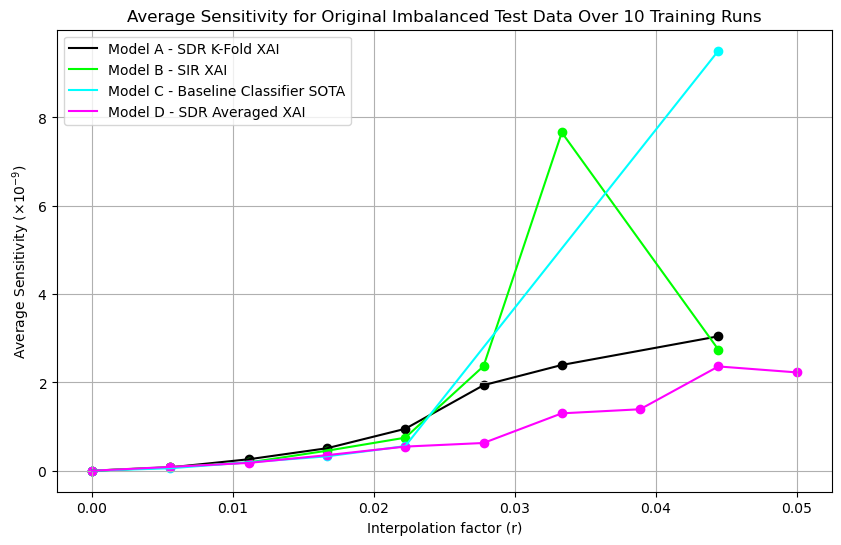

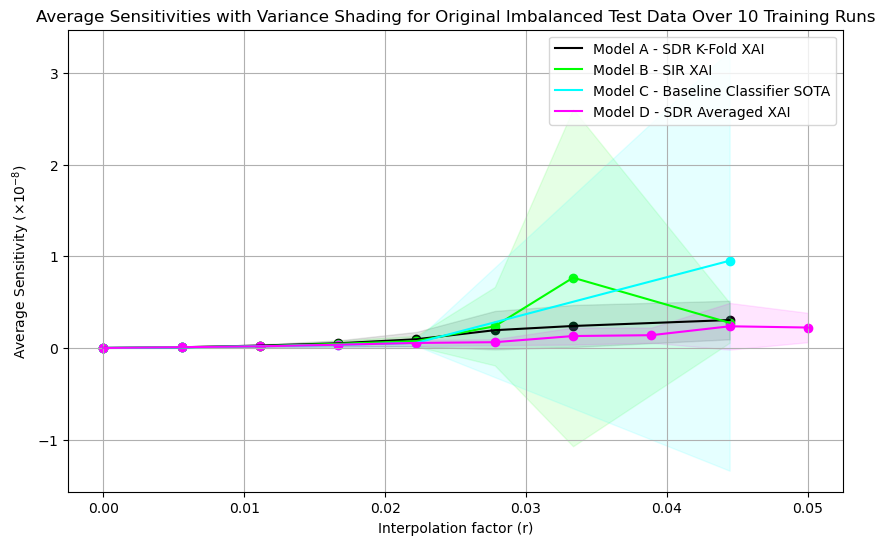

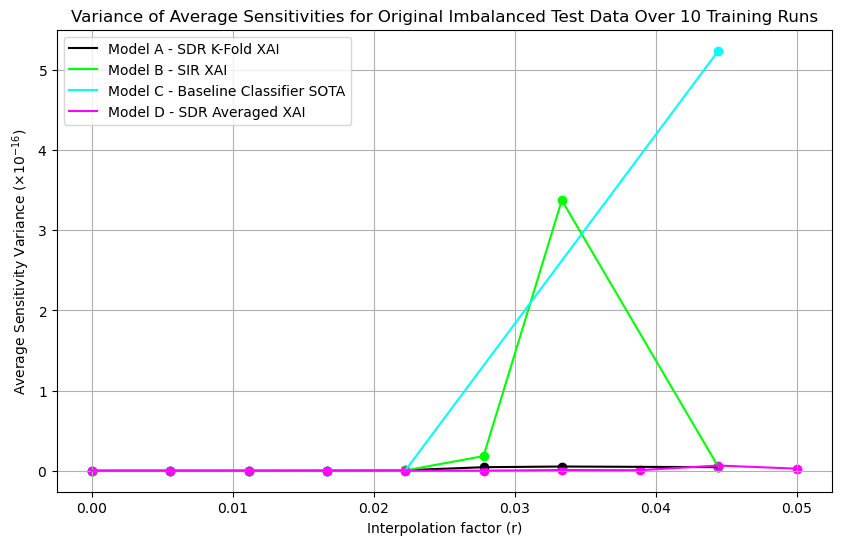

In [141]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter


def interpolate_with_given_noise(data, r):
    # calculate the range for Gaussian and standatize it to use 1% of the range for the noise geenration
    noise_range = (data.max(axis=0) - data.min(axis=0))
    
    # generate Gaussian noise with mean 0 and the calculated standard deviation
    noise = np.random.normal(0, np.abs(noise_range), size=data.shape)
    
    # interpolate the original data with the generated noise
    return (1 - r) * data + r * noise


# create a SHAPE explainer for the given model and background data
def create_explainer(model, background_data):
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, background_data_tensor)
    return explainer

# compute the average sensitivity for the given model and data, mse is used as the distance metric
def compute_average_sensitivity(model, data, r, num_samples=100, background_size=1000):
    # generate the background data
    random_indices = np.random.choice(len(data), size=background_size, replace=False)
    background_data = data[random_indices]

    explainer = create_explainer(model, background_data)
    
    # generate the data subset for which the average sensitivity is computed
    indices = np.random.choice(len(data), size=num_samples, replace=False)
    data_subset = data[indices]
    data_tensor = torch.tensor(data_subset, dtype=torch.float32).to(device)

    # find the SHAP values for the original data
    shap_values_original = explainer.shap_values(data_tensor)
    shap_values_original = np.array(shap_values_original)
    
    # find the predictions for the original data
    preds_original = model(data_tensor).detach().cpu().numpy()

    mse_differences = []
    
    for i in range(num_samples):
        # interpolate the original data with noise
        perturbed_data = interpolate_with_given_noise(data_subset[i:i+1], r)
        perturbed_data_tensor = torch.tensor(perturbed_data, dtype=torch.float32).to(device)
        
        # predictions for the perturbed data
        preds_perturbed = model(perturbed_data_tensor).detach().cpu().numpy()
        
        # if the predictions for the original and perturbed data are the same, find the SHAP values for the perturbed data
        if np.allclose(preds_original[i], preds_perturbed, atol=1e-5):
            shap_values_perturbed = explainer.shap_values(perturbed_data_tensor)
            shap_values_perturbed = np.array(shap_values_perturbed)
            
            # MSE as the metric for distance between SHAP values
            mse = np.mean((shap_values_original[i] - shap_values_perturbed) ** 2)
            mse_differences.append(mse)
    
    return np.mean(mse_differences)


base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]


# adapt as the percentage of test data
perturb_radii = np.linspace(0, 0.05, 10)
average_sensitivities = {}
average_sensitivities_var = {}


for r in perturb_radii:
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)

            # adapt if needed
            sensitivity = compute_average_sensitivity(model, test_hold, r)
            sensitivity_list.append(sensitivity)
        
        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list))
        average_sensitivities_var.setdefault(folder, []).append(np.var(sensitivity_list))


df_avg_sensitivities = pd.DataFrame(average_sensitivities)
df_avg_sensitivities['perturb_radius'] = perturb_radii
df_avg_sensitivities.to_csv(os.path.join(base_dir, 'avg_sensitivities_100_not_scaled.csv'), index=False)

df_avg_sensitivities_var = pd.DataFrame(average_sensitivities_var)
df_avg_sensitivities_var['perturb_radius'] = perturb_radii
df_avg_sensitivities_var.to_csv(os.path.join(base_dir, 'avg_sensitivities_var_100_not_scaled.csv'), index=False)

# Use the same color and model names mapping as before
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found



def format_ylabel(ax, label):
    # Use the ticklabel_format to force scientific notation
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    
    # Get the offset text, which is the scientific notation exponent
    offset_text = ax.yaxis.get_offset_text().get_text()
    if offset_text:
        ax.yaxis.offsetText.set_visible(False)
        label_with_offset = f"{label} ({offset_text})"
    else:
        label_with_offset = label
    
    ax.set_ylabel(label_with_offset, fontsize=10)
    return ax

# Plot 1: Average Sensitivities
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Filter out None or NaN values and their corresponding radii
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color) 
format_ylabel(ax1, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivity for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Average Sensitivities with Variance Shading
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Calculate standard deviations while ignoring NaN values
    std_devs = np.sqrt(np.nan_to_num(average_sensitivities_var[model_file_name]))
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    valid_std_devs = std_devs[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color)  # Add dots
    plt.fill_between(valid_radii,
                     valid_sensitivities - valid_std_devs,
                     valid_sensitivities + valid_std_devs,
                     color=color, alpha=0.1)
format_ylabel(ax2, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities with Variance Shading for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Variance of Sensitivities
plt.figure(figsize=(10, 6))
ax3 = plt.gca()
for model_file_name, sensitivity_values_var in average_sensitivities_var.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Ignore NaN values for plotting
    valid_indices = ~np.isnan(sensitivity_values_var)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities_var = np.array(sensitivity_values_var)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities_var, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities_var, color=color)  # Add dots
format_ylabel(ax3, "Average Sensitivity Variance")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Variance of Average Sensitivities for Original Imbalanced Test Data Over 10 Training Runs")
plt.show()

### Average Sensitivity for balanced data

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Mean of empty slice.
invalid value encountered in scalar divide


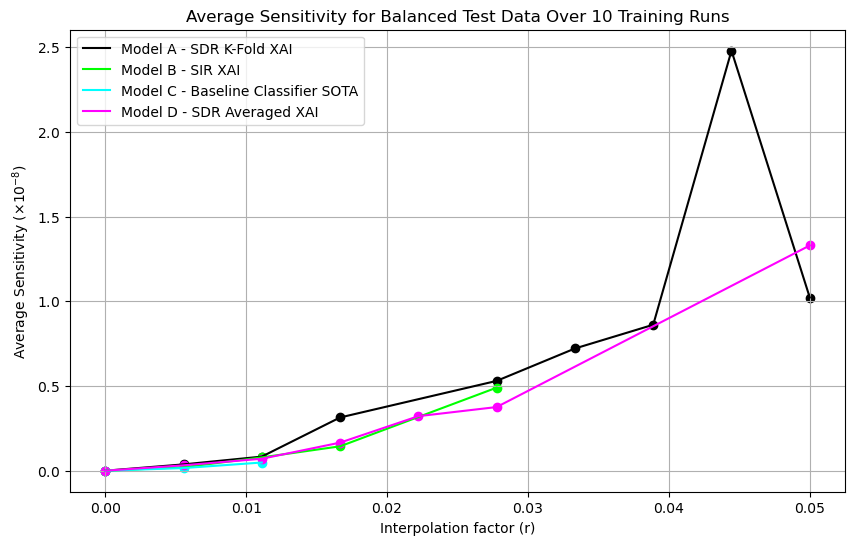

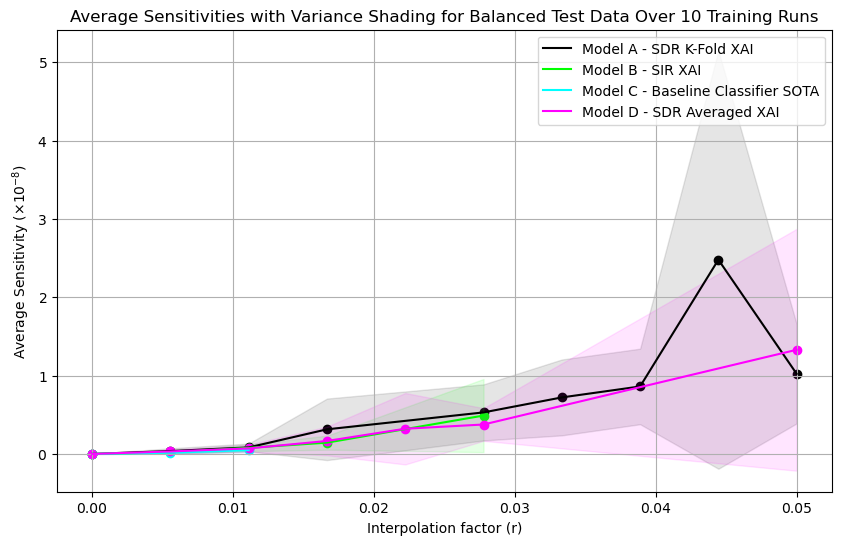

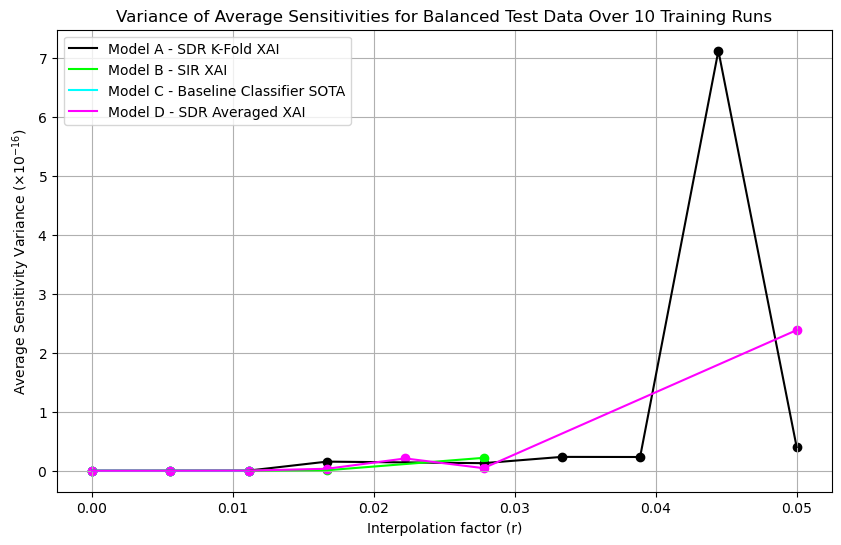

In [135]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import shap
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter


def interpolate_with_given_noise(data, r):
    # Calculate the range for Gaussian noise based on the percentage
    noise_range = (data.max(axis=0) - data.min(axis=0)) 
    
    # Generate Gaussian noise with mean 0 and the calculated standard deviation
    noise = np.random.normal(0, np.abs(noise_range), size=data.shape)
    
    # Interpolate the original data with the generated noise
    return (1 - r) * data + r * noise

def create_explainer(model, background_data):
    background_data_tensor = torch.tensor(background_data, dtype=torch.float32).to(device)
    explainer = shap.DeepExplainer(model, background_data_tensor)
    return explainer


def compute_average_sensitivity(model, data, r, num_samples=100, background_size=1000):
    random_indices = np.random.choice(len(data), size=background_size, replace=False)
    background_data = data[random_indices]

    explainer = create_explainer(model, background_data)
    
    indices = np.random.choice(len(data), size=num_samples, replace=False)
    data_subset = data[indices]
    data_tensor = torch.tensor(data_subset, dtype=torch.float32).to(device)

    shap_values_original = explainer.shap_values(data_tensor)
    shap_values_original = np.array(shap_values_original)
    
    preds_original = model(data_tensor).detach().cpu().numpy()

    mse_differences = []
    for i in range(num_samples):
        # Interpolate the original data with noise
        perturbed_data = interpolate_with_given_noise(data_subset[i:i+1], r)
        perturbed_data_tensor = torch.tensor(perturbed_data, dtype=torch.float32).to(device)
        
        # Predictions for the perturbed data
        preds_perturbed = model(perturbed_data_tensor).detach().cpu().numpy()
        
        if np.allclose(preds_original[i], preds_perturbed, atol=1e-5):
            shap_values_perturbed = explainer.shap_values(perturbed_data_tensor)
            shap_values_perturbed = np.array(shap_values_perturbed)
            mse = np.mean((shap_values_original[i] - shap_values_perturbed) ** 2)
            mse_differences.append(mse)
    
    return np.mean(mse_differences)




base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]


# adapt as the percentage of normalized data
perturb_radii = np.linspace(0, 0.05, 10)
average_sensitivities = {}
average_sensitivities_var = {}

# Example usage of the modified function in your main script
for r in perturb_radii:
    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)
        sensitivity_list = []

        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval().to(device)

            # Using a fixed percentage for noise, adjust as needed
            sensitivity = compute_average_sensitivity(model, data_resampled, r)
            sensitivity_list.append(sensitivity)
        
        average_sensitivities.setdefault(folder, []).append(np.mean(sensitivity_list))
        average_sensitivities_var.setdefault(folder, []).append(np.var(sensitivity_list))


df_avg_sensitivities = pd.DataFrame(average_sensitivities)
df_avg_sensitivities['perturb_radius'] = perturb_radii
df_avg_sensitivities.to_csv(os.path.join(base_dir, 'avg_sensitivities_100_resampled.csv'), index=False)

df_avg_sensitivities_var = pd.DataFrame(average_sensitivities_var)
df_avg_sensitivities_var['perturb_radius'] = perturb_radii
df_avg_sensitivities_var.to_csv(os.path.join(base_dir, 'avg_sensitivities_var_100_resampled.csv'), index=False)

# Use the same color and model names mapping as before
model_names = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'Model A - SDR K-Fold XAI',
    'sir_intensity_total_shap_10_aplha03': 'Model B - SIR XAI',
    'binary_classifier_sota_10': 'Model C - Baseline Classifier SOTA',
    'sdr_average_10_aplha03_1000_l1': 'Model D - SDR Averaged XAI'
}

color_mapping = {
    'sdr_kfold_shap_10_aplha03_25_1000_l1': 'black',
    'sir_intensity_total_shap_10_aplha03': 'lime',
    'binary_classifier_sota_10': 'cyan',
    'sdr_average_10_aplha03_1000_l1': 'magenta'
}

# Function to get color for a model
def get_model_color(model_name):
    return color_mapping.get(model_name, 'gray')  # Default to 'gray' if model not found



def format_ylabel(ax, label):
    # Use the ticklabel_format to force scientific notation
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    
    # Get the offset text, which is the scientific notation exponent
    offset_text = ax.yaxis.get_offset_text().get_text()
    if offset_text:
        ax.yaxis.offsetText.set_visible(False)
        label_with_offset = f"{label} ({offset_text})"
    else:
        label_with_offset = label
    
    ax.set_ylabel(label_with_offset, fontsize=10)
    return ax



# Plot 1: Average Sensitivities
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Filter out None or NaN values and their corresponding radii
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color)  # Add dots
format_ylabel(ax1, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivity for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 2: Average Sensitivities with Variance Shading
plt.figure(figsize=(10, 6))
ax2 = plt.gca()
for model_file_name, sensitivity_values in average_sensitivities.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Calculate standard deviations while ignoring NaN values
    std_devs = np.sqrt(np.nan_to_num(average_sensitivities_var[model_file_name]))
    valid_indices = ~np.isnan(sensitivity_values)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities = np.array(sensitivity_values)[valid_indices]
    valid_std_devs = std_devs[valid_indices]
    plt.plot(valid_radii, valid_sensitivities, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities, color=color)  # Add dots
    plt.fill_between(valid_radii,
                     valid_sensitivities - valid_std_devs,
                     valid_sensitivities + valid_std_devs,
                     color=color, alpha=0.1)
format_ylabel(ax2, "Average Sensitivity")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Average Sensitivities with Variance Shading for Balanced Test Data Over 10 Training Runs")
plt.show()

# Plot 3: Variance of Sensitivities
plt.figure(figsize=(10, 6))
ax3 = plt.gca()
for model_file_name, sensitivity_values_var in average_sensitivities_var.items():
    color = get_model_color(model_file_name)
    label = model_names.get(model_file_name, model_file_name)
    # Ignore NaN values for plotting
    valid_indices = ~np.isnan(sensitivity_values_var)
    valid_radii = perturb_radii[valid_indices]
    valid_sensitivities_var = np.array(sensitivity_values_var)[valid_indices]
    plt.plot(valid_radii, valid_sensitivities_var, label=label, color=color)
    plt.scatter(valid_radii, valid_sensitivities_var, color=color)  # Add dots
format_ylabel(ax3, "Average Sensitivity Variance")
plt.xlabel("Interpolation factor (r)")
plt.legend()
plt.grid(True)
plt.title("Variance of Average Sensitivities for Balanced Test Data Over 10 Training Runs")
plt.show()


## Accuracy vs. Average Sensitivity

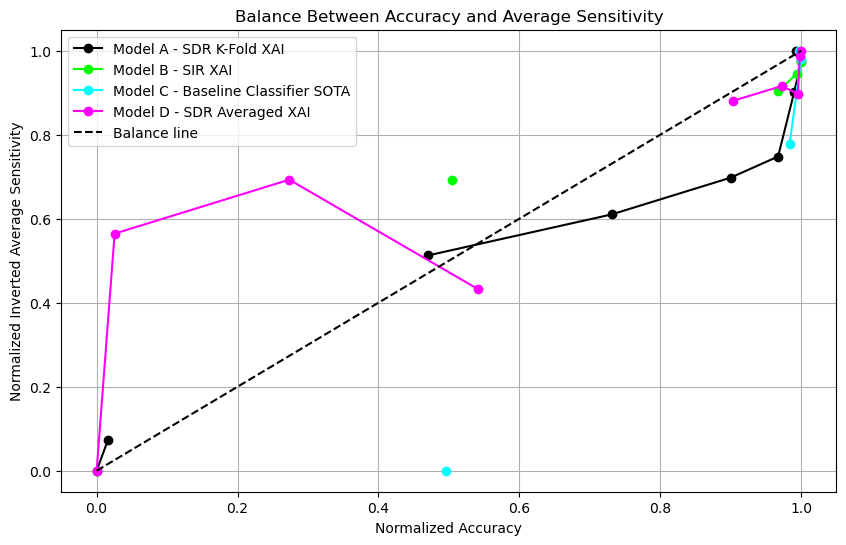

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the data
df_accuracy = pd.read_csv('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/average_accuracies_imbalanced.csv')
df_sensitivity = pd.read_csv('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new/avg_sensitivities_100_100.csv')



# Normalize the data
scaler = MinMaxScaler()
df_accuracy_normalized = scaler.fit_transform(df_accuracy.drop(['r_value'], axis=1))
df_sensitivity_normalized = 1 -  scaler.fit_transform(df_sensitivity.drop(['perturb_radius'], axis=1))

# Adding normalized data back to the dataframes
df_accuracy[df_accuracy.columns[:-1]] = df_accuracy_normalized  # Exclude the 'r_value' column
df_sensitivity[df_sensitivity.columns[:-1]] = df_sensitivity_normalized  # Exclude the 'perturb_radius' column

# Merge dataframes by index
df_merged = pd.merge(df_accuracy, df_sensitivity, left_index=True, right_index=True)

# Plotting
plt.figure(figsize=(10, 6))

# Use the model names and color mapping
for model_key in model_names.keys():
    plt.plot(
        df_merged[model_key + '_x'], 
        df_merged[model_key + '_y'], 
        label=model_names[model_key], 
        color=get_model_color(model_key), 
        marker='o'
    )
# Add diagonal line to show balance
plt.plot([0, 1], [0, 1], 'k--', label='Balance line')
plt.xlabel('Normalized Accuracy')
plt.ylabel('Normalized Inverted Average Sensitivity')
plt.title('Balance Between Accuracy and Average Sensitivity')
plt.legend()
plt.grid(True)
plt.show()


## Other Performance Metrics

In [158]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def get_predictions_and_probs(model, data):
    # Convert data to a tensor if it's not already one
    if not isinstance(data, torch.Tensor):
        data = torch.Tensor(data)
    
    # Move data to the same device as the model
    data = data.to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probabilities = torch.sigmoid(logits)
    
    predicted_labels = (probabilities > 0.5).float().cpu().numpy()
    predicted_probs = probabilities.cpu().numpy().squeeze()

    return predicted_labels, predicted_probs

def get_metrics_averaged_by_model_type(model_folders, test_data, test_label):
    metrics_by_model_type = {}

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)
            
            predicted_labels, predicted_probs = get_predictions_and_probs(model, test_data)
            
            precision = precision_score(test_label, predicted_labels)
            recall = recall_score(test_label, predicted_labels)
            f1 = f1_score(test_label, predicted_labels)
            roc_auc = roc_auc_score(test_label, predicted_probs)
            
            metrics = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "roc_auc": roc_auc
            }
            
            accuracies.append(metrics)
        
        metrics_by_model_type[folder] = {
            "precision": np.mean([metrics["precision"] for metrics in accuracies]),
            "recall": np.mean([metrics["recall"] for metrics in accuracies]),
            "f1": np.mean([metrics["f1"] for metrics in accuracies]),
            "roc_auc": np.mean([metrics["roc_auc"] for metrics in accuracies])
        }

    return metrics_by_model_type


In [159]:
# Directory containing all model type folders
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/past_values_10_03_new"


# Get a list of all folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

metrics_by_model_type = get_metrics_averaged_by_model_type(model_folders, test_hold, test_label)
print(metrics_by_model_type)


{'sdr_kfold_shap_10_aplha03_25_1000_l1': {'precision': 0.19625178633679474, 'recall': 0.998046875, 'f1': 0.32795913204412275, 'roc_auc': 0.9071848695888687}, 'sir_intensity_total_shap_10_aplha03': {'precision': 0.1957480878840641, 'recall': 0.9974609375, 'f1': 0.3272163721258717, 'roc_auc': 0.9129977650452361}, 'binary_classifier_sota_10': {'precision': 0.19271636044029208, 'recall': 1.0, 'f1': 0.32314462041350367, 'roc_auc': 0.9237106064618645}, 'sdr_average_10_aplha03_1000_l1': {'precision': 0.19360992417466316, 'recall': 0.999609375, 'f1': 0.32438266964672935, 'roc_auc': 0.9151554179311729}}
